# GRB 190829A 1D-spectral analysis 

## Reflected BKG MODEL ESTIMATION

### Prerequesties

- To be able to extract the spectral data points, one should undersatand how to extract the spectrum in the Cherenkov Astronomy, especially the OFF background measurements.

- The second one would be also understand the basics of data reduction and how the modelling process in gammapy is done.

### Theoritical context

- In classical Cherenkov Astronomy, spectral analysis which is the simplest where all data inside ON region are binned in 1D-datasets, is used for a specific background estimation technique that uses off measurements taken into the FoV in regions, where the background rate is assumed to be equal to the one in ON region.

- This is useful as it helps to use a specific fit statistics  known as Wstat (`~ gammapy.stats.fit_statistics`). 
- In such case no background model is assumed.
- In this case the background is treated as a set of nuissance parameters and it removes some systematic related to the choice or the quality of the background. 

- On the other hand, this comes with an expense of larger statistical uncertainties on the fitted parameters.

- In this notebook, I aim at performing a full region based spectral analysis of GRB 190829A observations of HESS detected in 2019 (`See H.E.S.S collaboration, 2021 in science Nature`).


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Check package versions
import gammapy
import numpy as np
import astropy
import regions

print("gammapy:", gammapy.__version__)
print("numpy:", np.__version__)
print("astropy", astropy.__version__)
print("regions", regions.__version__)

gammapy: 0.17
numpy: 1.18.1
astropy 4.0.3
regions 0.4


In [3]:
from pathlib import Path
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.maps import Map
from gammapy.modeling import Fit
from gammapy.data import DataStore
from gammapy.datasets import (
    Datasets,
    SpectrumDataset,
    SpectrumDatasetOnOff,
    FluxPointsDataset,
)
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
)
from gammapy.makers import (
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
)
from gammapy.estimators import FluxPointsEstimator
from gammapy.visualization import plot_spectrum_datasets_off_regions

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Save plots and format figures

In [5]:
work_dir = "/Users/jean/Documents/PhD/gammapy/GRBs/190829A/v17/new_analysis/grb_analysis/"

def save(fig, figname, left = 0.15, bottom = 0.15, right = 0.95, top = 0.95):
    fig.subplots_adjust(left = left, bottom = bottom, top = top, right = right)
    format_fig = ['png','pdf'] # 'eps'
    for form in format_fig:
        fig.savefig(work_dir + "plots/plots_1D/{}/jupyter_notebooks/grb190829A_{}_{}.{}"
                    .format(run_list,run_list, figname, form))
W = 10

params = {'figure.figsize': (W, W/(4/3)),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
          'font.size' : 16,
         'text.usetex': True,
          'font.family': "sans-serif",
          'legend.fontsize': 16,
          }
plt.rcParams.update(params)

## Defining the datastore and selecting observations

- We first use the `~gammapy.data.DataStore` object to access the observations we want to analyse.
- Here it points to HESS IU period std_Impact data.

#### Load Data
- First, we select and load H.E.S.S. observations of the GRB 190829A (real data).

- We will access the events, effective area, energy dispersion, livetime and PSF for containement correction.

In [6]:
def get_runlist(run_list):
    cluster1 = [152900, 152901]
    cluster2 = [152902, 152903, 152904]
    cluster3 = [152905, 152906, 152907]

    runs_night1 = [152900, 152901, 152902, 152903, 152904, 152905, 152906, 152907]
    runs_hybrid = [152900, 152901, 152902, 152903, 152904, 152905]
    runs_night2 = [152960, 152961, 152962, 152963, 152965, 152966, 152967, 152968, 152969, 152970]
    runs_night3 = [153040, 153041, 153042, 153043, 153044, 153047, 153048, 153049, 153050] # 153045 (too short)


    options = ["night1","night2","night3","all","cluster1","cluster2","cluster3"]

    if run_list not in options:
        print("Invalid option,use\n")
        print(options)
        return []

    else:
        if run_list == 'night1':
            runs = runs_night1
        elif run_list == 'night2':
            runs = runs_night2
        elif run_list == 'night3':
            runs = runs_night3
        elif run_list == 'all':
            runs = runs_night1 + runs_night2 + runs_night3
        elif run_list == "cluster1":
            runs = cluster1
        elif run_list == "cluster2":
            runs = cluster2
        elif run_list == "cluster3":
            runs = cluster3
        elif run_list == "hybrid":
            runs = runs_hybrid
        return runs


def load_data(runs):
    # Load FITS data from H.E.S.S database/local cpu
    ds = DataStore.from_dir('$GAMMAPY_DATA/std_ImPACT_fullEnclosure')
    observations = ds.get_observations(runs)

    return observations, ds


- If we have no observation list, we can define an observation filter to select only the relevant observations. Thanks because for now we have a specific runlist from a specific source. 

- The `ObservationTable` contains a summary table of all observations contained in the `DataStore`. We can apply a filter on it with `~gammapy.data.ObservationTable.select_observations()`.
- Here we can use a cone, or other search which we define with a python dict.

## Create a function to Computing residuals

In [7]:
def my_residuals(self, method = "diff"):
    fp = self.data
    data = fp.table[fp.sed_type]

    model = self.flux_pred()

    residuals = self._compute_residuals(data, model, method)
    # Remove residuals for upper_limits
    residuals[fp.is_ul] = np.nan

    fp = self.data

    model = self.flux_pred()
    yerr = fp._plot_get_flux_err(fp.sed_type)

    if method == "diff":
        unit = yerr[0].unit
        yerr = yerr[0].to_value(unit), yerr[1].to_value(unit)
    elif method == "diff/model":
        unit = ""
        yerr = (yerr[0] / model).to_value(""), (yerr[1] / model).to_value(unit)
    else:
        raise ValueError("Invalid method, choose between 'diff' and 'diff/model'")

    return residuals, yerr

In [8]:
name_file1 = 'reflectedBg_night1_joint_jupyter'
name_file2 = 'reflectedBg_night1_stacked_jupyter'


print(name_file1 , '\n'+ name_file2)
run_list = 'night1'
# we load the data here:
runs = get_runlist(run_list)

observations, datastore = load_data(runs)

#print(observations)

reflectedBg_night1_joint_jupyter 
reflectedBg_night1_stacked_jupyter


## Define Source Region

- The next step is to define a signal extraction region, also known as on-region. 

- In the simplest case this is just a CircleSkyRegion, but here we will use the Target class in gammapy that is useful for book-keeping if you run several analysis in a script.

- Configure the target and on/exclusion region(s) here we will add an exclusion region for the star at 0.4 deg away from the GRB just to be on the safe side.

In [9]:
target_position = SkyCoord(ra=44.544, dec=-8.958, unit="deg", frame="icrs")
on_region_radius = Angle("0.071 deg") # thetasqr= 0.05 deg
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

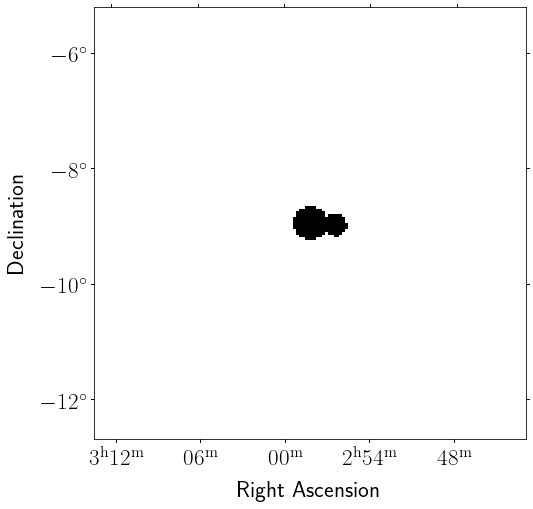

In [10]:
exclusion_region_grb = CircleSkyRegion(
    center=SkyCoord(44.544, -8.958, unit="deg", frame="icrs"),
    radius=0.3 * u.deg,
)

exclusion_region_star = CircleSkyRegion(
    center=SkyCoord(44.106, -8.9891, unit="deg", frame="icrs"),
    radius=0.2 * u.deg,
)
skydir = target_position.icrs
exclusion_mask = Map.create(
    npix=(150, 150), binsz=0.05, skydir=skydir, proj="TAN", frame="icrs"
)

mask = exclusion_mask.geom.region_mask([exclusion_region_grb, exclusion_region_star], inside=False)
exclusion_mask.data = mask

fig = plt.figure()
exclusion_mask.plot();
save(fig, "exclusion_mask_reflectedbkg_night1")

## Define the geometries

- This part is especially important. 
- We have to define first energy axes. They define the axes of the resulting `~gammapy.datasets.SpectrumDatasetOnOff`. In particular, we have to be careful to the true energy axis: it has to cover a larger range than the reconstructed energy one.
- Then we define the geometry itself. It does not need to be very finely binned and should enclose all the ON region. To limit CPU and memory usage, one should avoid using a much larger region.

In [11]:
e_reco = np.logspace(-1, np.log10(100), 49) * u.TeV
e_true = np.logspace(np.log10(0.05), 2, 200) * u.TeV
#energy_axis = MapAxis.from_edges(np.logspace(-1, 2, 49), unit='TeV', name='energy', interp='log')

## Create makers

In [12]:
dataset_maker = SpectrumDatasetMaker(
containment_correction=True, selection=["counts", "aeff", "edisp"]
)

bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)#, binsz="0.05 deg")
safe_mask_masker = SafeMaskMaker(methods=["aeff-default", "edisp-bias"], bias_percent=10)

dataset_empty = SpectrumDataset.create(
e_reco=e_reco, region=on_region
)

## Run data reduction chain

In [13]:

%%time
datasets = Datasets()

for obs_id, observation in zip(runs, observations):
    dataset = dataset_maker.run(
        dataset_empty.copy(name=str(obs_id)), observation
    )
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    datasets.append(dataset_on_off)

CPU times: user 2.74 s, sys: 161 ms, total: 2.9 s
Wall time: 3.06 s


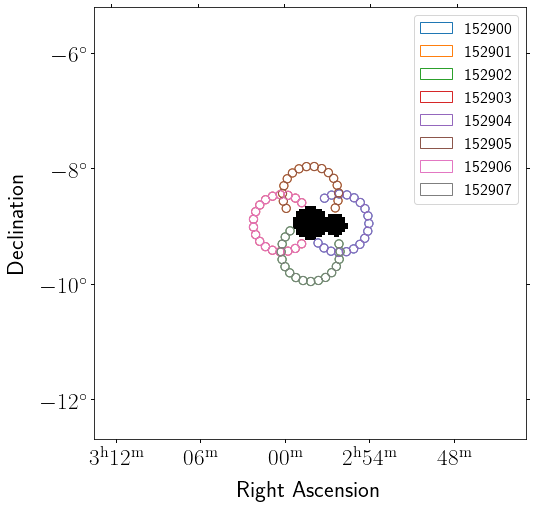

In [14]:
fig = plt.figure()
_, ax, _ = exclusion_mask.plot()
on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor="k")
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)
save(fig, "reflected_region_with_exclusion")

## Source statistic

- We’re going to look at the overall source statistics in our signal region.

In [15]:
info_table = datasets.info_table(cumulative=True)

In [16]:
info_table

name,livetime,n_on,background,excess,significance [1],background_rate,gamma_rate,a_on,n_off,a_off,alpha
,s,,,,,1 / s,1 / s,,,,
str7,float64,float32,float64,float64,float64,float64,float64,float64,float32,float64,float64
stacked,1682.0,24.0,3.9444444444444446,20.055555555555557,6.451444288904131,0.0023450918219051395,0.011923635883207823,1.0,71.0,18.0,0.05555555555555555
stacked,3364.0,55.0,7.75694465637207,47.24305725097656,10.322387826774527,0.0023058693984459185,0.014043714997317646,1.0,132.0,17.017009735107422,0.058764729648828506
stacked,5046.0,94.0,11.404003143310547,82.59600067138672,14.208330000802903,0.0022600085500020903,0.016368608932102006,1.0,194.0,17.01156997680664,0.05878352373838425
stacked,6728.0,128.0,16.237337112426758,111.76266479492188,16.354657959296055,0.0024133973115973185,0.01661157324538078,1.0,281.0,17.30579376220703,0.05778411775827408
stacked,8410.0,165.0,21.737335205078125,143.26266479492188,18.342450072607765,0.0025847009756335463,0.017034799618896774,1.0,380.0,17.481441497802734,0.057203520089387894
stacked,9862.0,192.0,26.737335205078125,165.26266479492188,19.3867384910034,0.0027111473539929145,0.016757520259067318,1.0,460.0,17.20440673828125,0.058124642819166183
stacked,11544.0,223.0,32.737335205078125,190.26266479492188,20.504844362018254,0.0028358744980143905,0.01648151981937993,1.0,568.0,17.350221633911133,0.05763615295290947
stacked,12240.0,241.0,34.972633361816406,206.02737426757812,21.406306165809152,0.0028572412877300984,0.016832301819246578,1.0,606.0,17.32783317565918,0.05771062150597572


In [17]:
print('Run   Threshold [TeV]\n')
print('----------------------\n')

# Show energy threshold for each run
min_energy = np.inf
for obs,ds in zip(observations, datasets):
    thres = ds.energy_range[0]
    min_energy = min(min_energy, thres)
    print(obs.obs_id, '{:.4g}'.format(min_energy))

info_table = datasets.info_table(cumulative = True)
print(" Table of source statistics:")
print('------------------------------\n')


#print('--------------------------------------------\n')

print(
'Excess Counts: '+'{:.6s}'.format(str(info_table['excess'][-1])) + '\n', 'On Counts: ' +'{:.6s}'.format( str(info_table['n_on'][-1]))+'\n',
 'Off Counts: '+'{:.6s}'.format(str( info_table['n_off'][-1])) + '\n', 'Livetime: ' + '{:.6s}'.format(str(info_table['livetime'][-1]/3600)) + '\n',
 'Alpha: ' + '{:.6s}'.format(str(info_table['alpha'][-1])) + '\n', 'Background: ' + '{:.6s}'.format(str(info_table['background'][-1])) + '\n',
  'Background_rate: '+ '{:.6s}'.format(str(info_table['background_rate'][-1])) +'\n', 'Excess rate: ' + '{:.6s}'.format(str(info_table['gamma_rate'][-1])) + '\n',
 'Excess/background: ' +'{:.6s}'.format(str(info_table['excess'][-1]/info_table['background'][-1])) + '\n', 'Significance: ' + '{:.6s}'.format(str(info_table['significance'][-1]))
 )

Run   Threshold [TeV]

----------------------

152900 0.3652 TeV
152901 0.3162 TeV
152902 0.2371 TeV
152903 0.2054 TeV
152904 0.2054 TeV
152905 0.1778 TeV
152906 0.1778 TeV
152907 0.1778 TeV
 Table of source statistics:
------------------------------

Excess Counts: 206.02
 On Counts: 241.0
 Off Counts: 606.0
 Livetime: 3.4
 Alpha: 0.0577
 Background: 34.972
 Background_rate: 0.0028
 Excess rate: 0.0168
 Excess/background: 5.8911
 Significance: [21.40


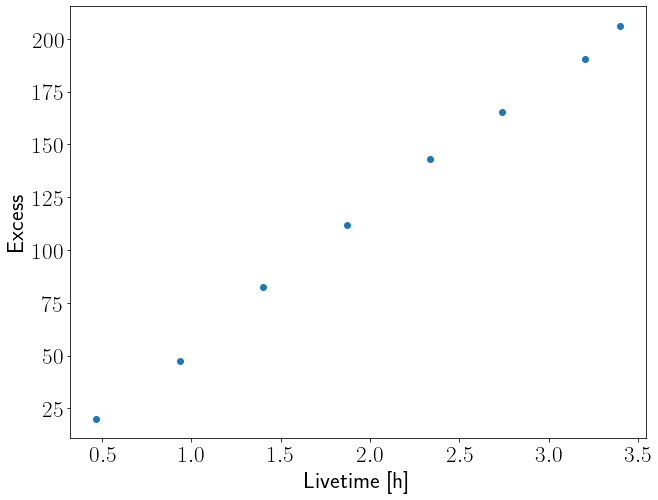

In [18]:
fig = plt.figure()
plt.plot(
    info_table["livetime"].to("h"), info_table["excess"], marker="o", ls="none"
)
plt.xlabel("Livetime [h]")
plt.ylabel("Excess");

save(fig, "Excess_vs_livetime")

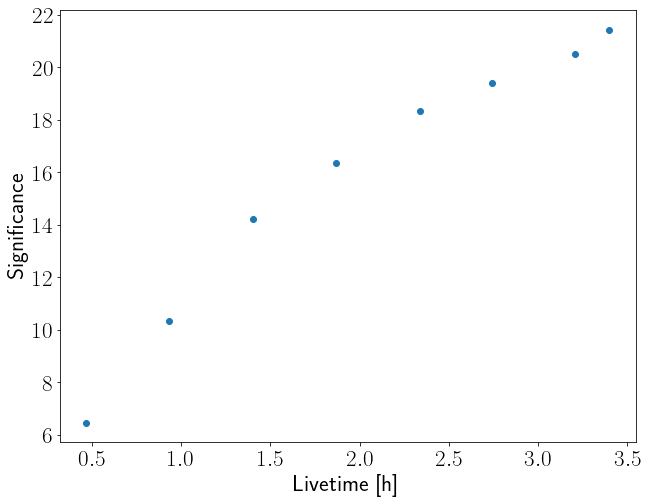

In [19]:
fig = plt.figure()
plt.plot(
    info_table["livetime"].to("h"),
    info_table["significance"],
    marker="o",
    ls="none",
)
plt.xlabel("Livetime [h]")
plt.ylabel("Significance");

save(fig, "Significance_vs_livetime")

152900


<Figure size 1440x1080 with 0 Axes>

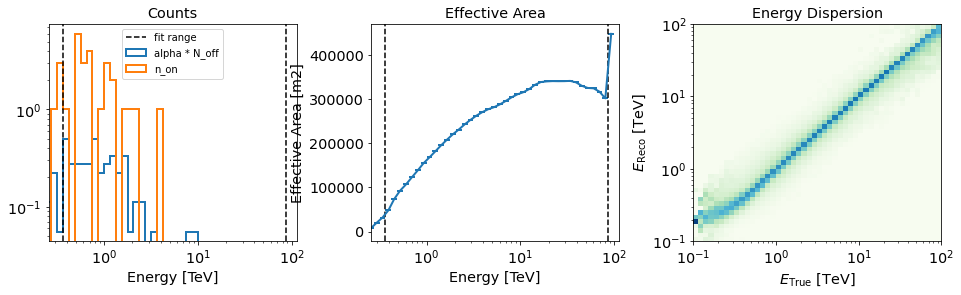

152901


<Figure size 1440x1080 with 0 Axes>

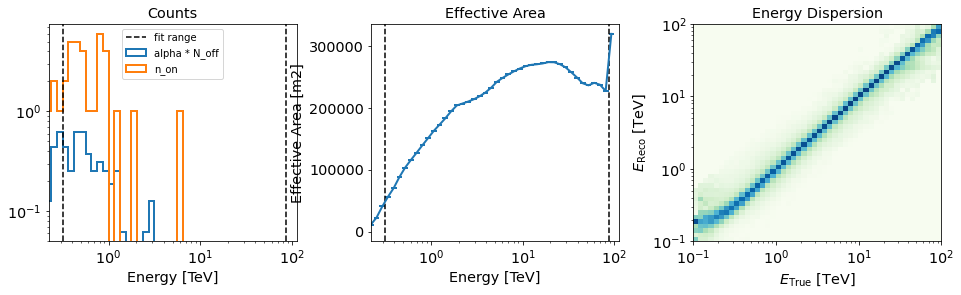

152902


<Figure size 1440x1080 with 0 Axes>

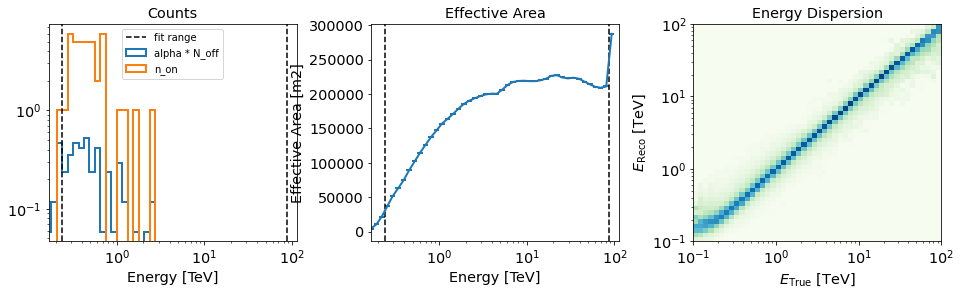

152903


<Figure size 1440x1080 with 0 Axes>

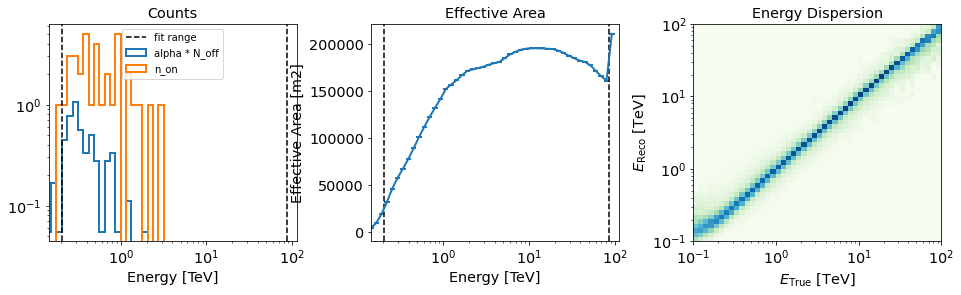

152904


<Figure size 1440x1080 with 0 Axes>

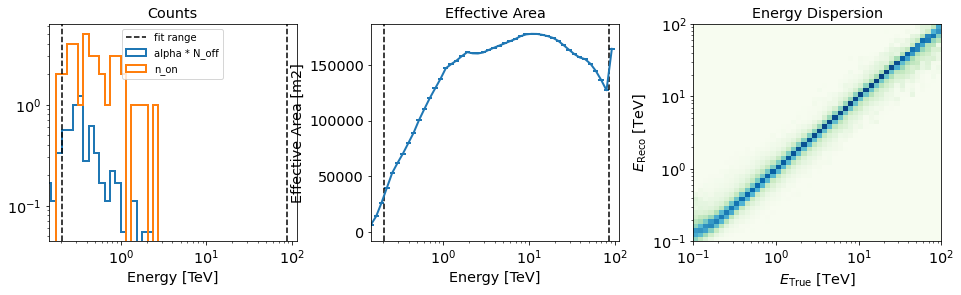

152905


<Figure size 1440x1080 with 0 Axes>

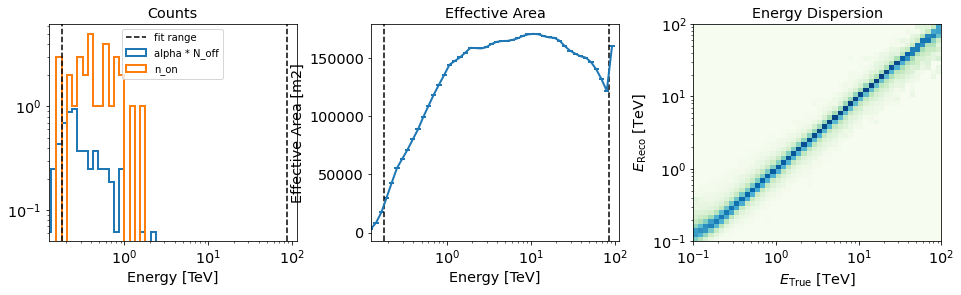

152906


<Figure size 1440x1080 with 0 Axes>

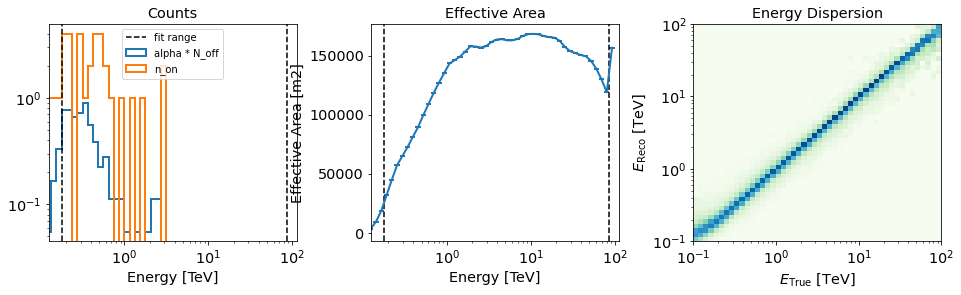

152907


<Figure size 1440x1080 with 0 Axes>

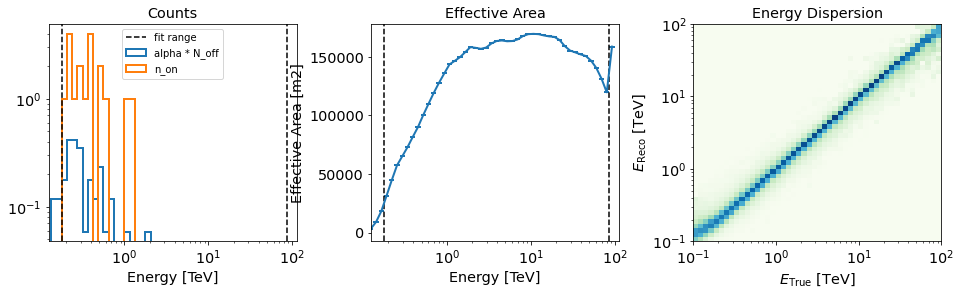

In [20]:
W = 20

params = {'figure.figsize': (W, W/(4/3)),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
          'font.size' : 10,
         'text.usetex': False,
          'font.family': "sans-serif",
          'legend.fontsize': 10,
          }
plt.rcParams.update(params)

for dataset, obs in zip(datasets, observations):
    print(obs.obs_id)
    fig = plt.figure()
    
    d= dataset.peek()
    
    s = plt.show();


## Saving data for later use

In [22]:
path = Path("../Data/1D_spectrum_datasets")
path.mkdir(exist_ok=True)

In [23]:
for dataset in datasets:
    dataset.to_ogip_files(outdir=path, overwrite=True)

- If you want to read back the datasets from disk you can use:

In [24]:
datasets = Datasets()
for obs_id in runs:
    filename = path / f"pha_obs{obs_id}.fits"
    datasets.append(SpectrumDatasetOnOff.from_ogip_files(filename))

### Fitting the spectrum

### Joint analysis
- Now we’ll fit a global model to the spectrum. First we do a joint likelihood fit to all observations. 
- If you want to stack the observations see below. We will also produce a debug plot in order to show how the global fit matches one of the individual observations.

In [32]:
spectral_model = PowerLawSpectralModel(
    index=2, amplitude=1.4e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=0.556 * u.TeV
)
model = SkyModel(spectral_model=spectral_model, name="grb")

for dataset in datasets:
    dataset.models = model


In [33]:
%%time
fit_joint = Fit(datasets)
result_joint = fit_joint.run()

# we make a copy here to compare it later
model_best_joint = model.copy()

CPU times: user 761 ms, sys: 6.55 ms, total: 767 ms
Wall time: 769 ms


In [34]:
print(result_joint)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 46
	total stat : 194.67



In [35]:
W = 10

params = {'figure.figsize': (W, W/(4/3)),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
          'font.size' : 16,
         'text.usetex': False,
          'font.family': "sans-serif",
          'legend.fontsize': 16,
          }
plt.rcParams.update(params)

## Inspect the model
- A simple way to inspect the model residuals is using the function `~SpectrumDataset.plot_fit()`.

152900


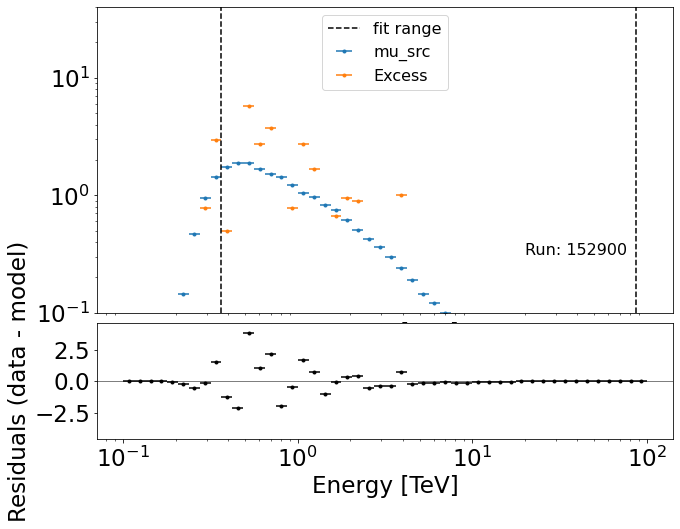

152901


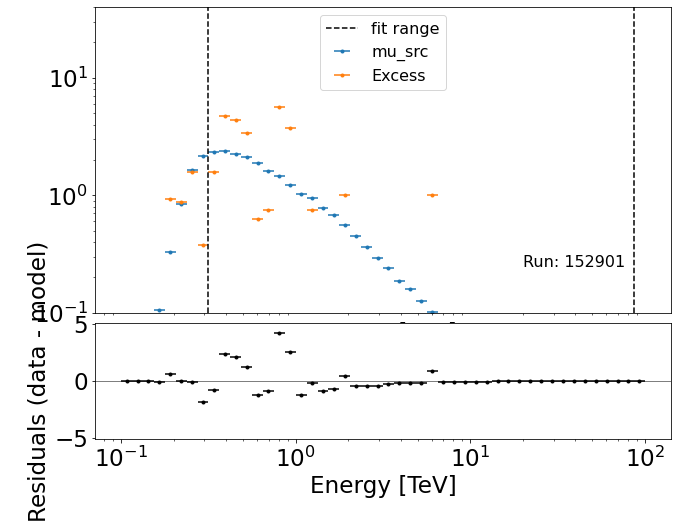

152902


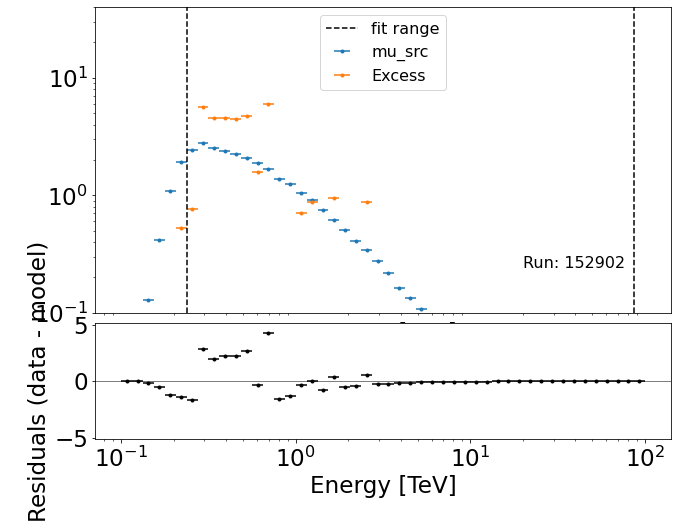

152903


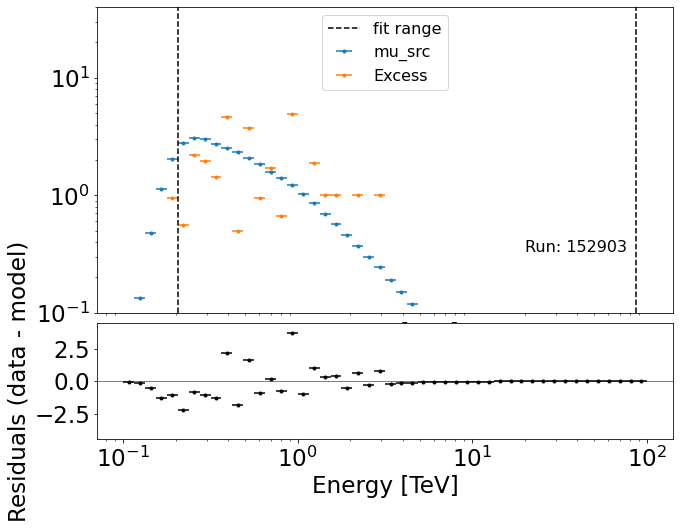

152904


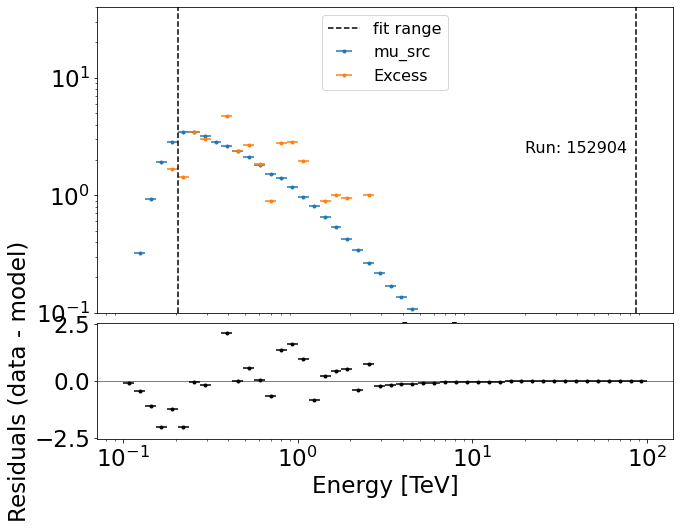

152905


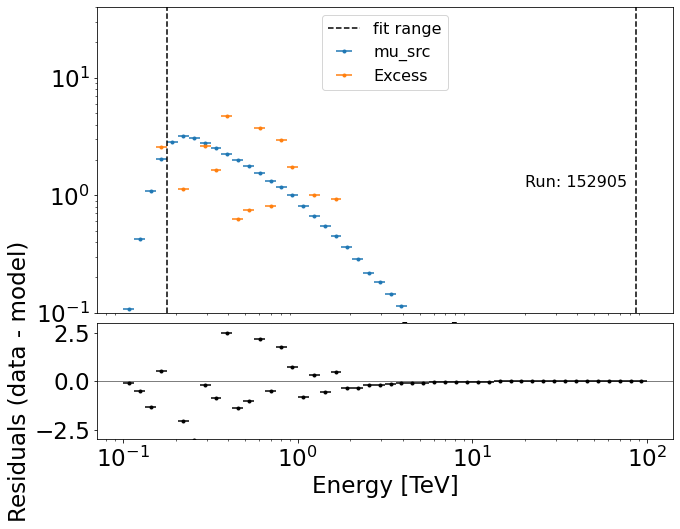

152906


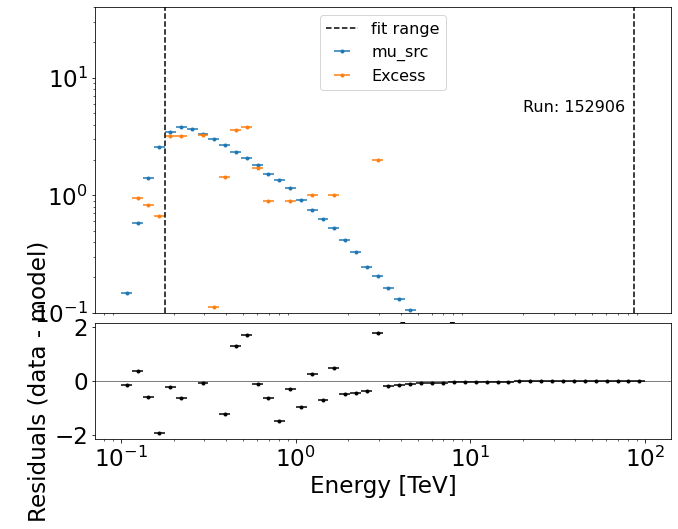

152907


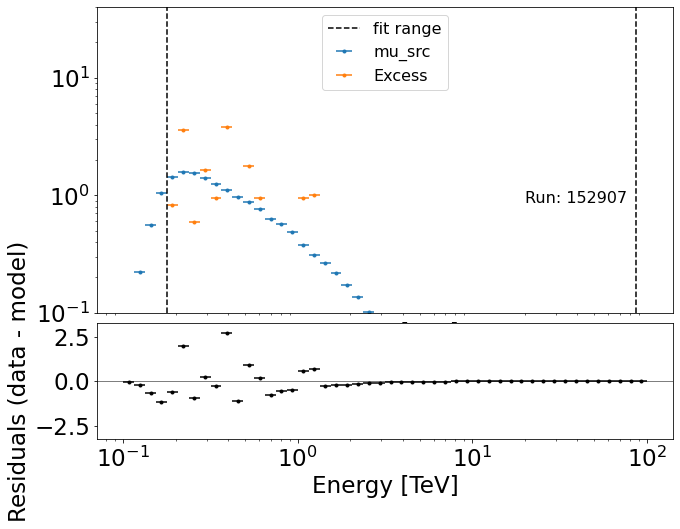

In [36]:
for dataset, obs in zip(datasets, observations):
    fig = plt.figure()
    print(obs.obs_id)
    ax_spectrum, ax_residual = dataset.plot_fit()
    ax_spectrum.set_ylim(0.1, 40)
    plt.text(20, 10, f'Run: {obs.obs_id}')
    save(fig, f"spectral_model_joint_{obs.obs_id}")
    
    plt.show()
    

## Checking the correlation matrix for the fitting parameters.

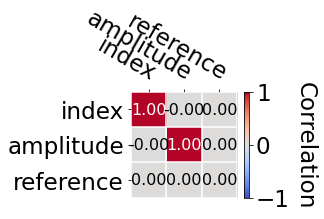

In [37]:
corr_parameters = model_best_joint.covariance.plot_correlation()

In [38]:
model_best_joint.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,2.596e+00,,nan,nan,False,9.201e-02
amplitude,1.394e-11,cm-2 s-1 TeV-1,nan,nan,False,1.054e-12
reference,5.560e-01,TeV,nan,nan,True,0.000e+00


### Compute Flux Points

- To round up our analysis we can compute flux points by fitting the norm of the global model in energy bands. We’ll use a fixed energy binning for now:

In [77]:
ebounds = np.logspace(-0.75, 0.52, 10)

ebounds = ebounds[ebounds.searchsorted(min_energy.value+1e-4)-1:]

- Now we create an instance of the `gammapy.estimators.FluxPointsEstimator`, by passing the dataset and the energy binning
- Finally we printout the table of the resulting flux points:


In [78]:
%%time
fpe = FluxPointsEstimator( e_edges = ebounds*u.TeV, reoptimize = True)

with np.errstate(divide='ignore', invalid='ignore'):
    flux_points = fpe.run(datasets=datasets)

CPU times: user 9.42 s, sys: 38.7 ms, total: 9.46 s
Wall time: 9.49 s


## Printing out the flux points.

In [79]:
flux_points.table_formatted

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,success,norm_err,norm_errp,norm_errn,norm_ul,sqrt_ts,ts,null_value,norm_scan [11],stat_scan [11],counts [8],dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64
0.205,0.178,0.237,1.851e-10,1.104e-11,2.249e-12,7.805e-12,0.577,9.722,True,0.194,0.205,0.176,1.018,4.270,18.233,0,0.200 .. 5.000,15.448 .. 141.133,0 .. 5,1.068e-10,1.884e-10,3.598e-11,3.798e-11,3.258e-11
0.294,0.237,0.365,7.273e-11,9.424e-12,2.727e-12,6.298e-12,0.695,20.789,True,0.134,0.140,0.128,0.989,7.645,58.448,0,0.200 .. 5.000,42.631 .. 297.919,0 .. 4,5.053e-11,7.193e-11,9.724e-12,1.021e-11,9.277e-12
0.422,0.365,0.487,2.858e-11,3.500e-12,1.465e-12,5.083e-12,1.322,22.035,True,0.199,0.220,0.201,1.783,10.476,109.755,0,0.200 .. 5.000,83.231 .. 145.890,1 .. 4,3.779e-11,5.096e-11,5.698e-12,6.302e-12,5.736e-12
0.562,0.487,0.649,1.354e-11,2.211e-12,1.234e-12,4.281e-12,1.434,10.383,True,0.249,0.251,0.226,1.960,10.502,110.293,0,0.200 .. 5.000,71.894 .. 105.894,9 .. 3,1.942e-11,2.653e-11,3.371e-12,3.399e-12,3.055e-12
0.750,0.649,0.866,6.413e-12,1.396e-12,1.039e-12,3.606e-12,1.205,30.580,True,0.247,0.266,0.235,1.770,8.042,64.680,0,0.200 .. 5.000,65.107 .. 116.510,4 .. 0,7.731e-12,1.135e-11,1.587e-12,1.707e-12,1.509e-12
1.075,0.866,1.334,2.520e-12,1.193e-12,1.260e-12,2.910e-12,1.291,28.106,True,0.246,0.271,0.241,1.865,8.744,76.451,0,0.200 .. 5.000,68.595 .. 110.972,6 .. 2,3.254e-12,4.700e-12,6.200e-13,6.840e-13,6.070e-13
1.540,1.334,1.778,9.904e-13,4.429e-13,6.768e-13,2.349e-12,0.755,11.054,True,0.299,0.332,0.262,1.496,4.731,22.383,0,0.200 .. 5.000,18.018 .. 62.906,1 .. 0,7.474e-13,1.482e-12,2.958e-13,3.293e-13,2.598e-13
2.054,1.778,2.371,4.692e-13,2.797e-13,5.701e-13,1.978e-12,0.704,9.821,True,0.358,0.408,0.302,1.635,3.370,11.359,0,0.200 .. 5.000,13.662 .. 45.593,2 .. 0,3.305e-13,7.672e-13,1.680e-13,1.913e-13,1.418e-13


## Plotting likelihood profile.

- We now plot the flux points and their likelihood profiles. 
- For the plotting of upper limits we choose a threshold of TS < 4.

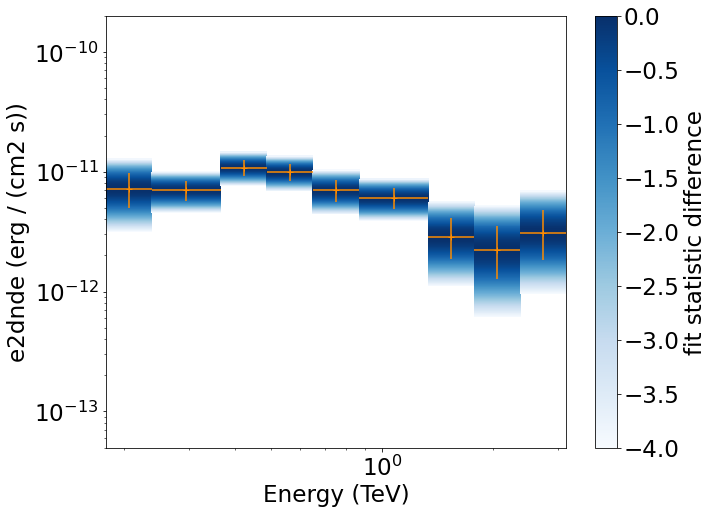

In [80]:
fig = plt.figure()
fp = flux_points.table["is_ul"] = flux_points.table["ts"] < 4
ax = flux_points.plot(
    energy_power=2, flux_unit="erg-1 cm-2 s-1", color="darkorange"
)
likelihood = flux_points.to_sed_type("e2dnde").plot_ts_profiles(ax=ax)
ax.set_ylim(5e-14, 2e-10);

save(fig, name_file1 + "TS_SED_profile")

- The final plot with the best fit model, flux points and residuals can be quickly made like this first for joint analysis:

In [81]:
flux_points_dataset = FluxPointsDataset(
    data=flux_points, models=model_best_joint
)

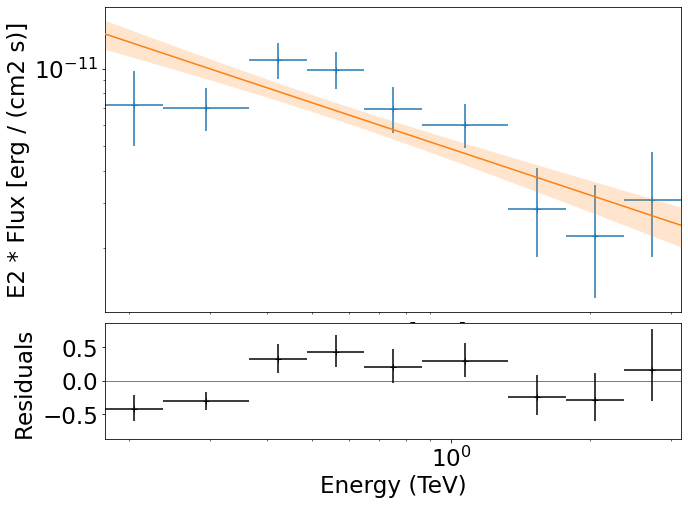

In [82]:
fig = plt.figure()
flux_points_dataset.peek();
save(fig, name_file1 + "flux_point_peek")

## Print and save flux point results.

In [83]:
print('Flux points\n')
print('Unit: TeV^-1 cm^-2 s^-1')
print('')
print('Energy [TeV]  |      Flux      |    Flux low    |    Flux high   |  Significance')
flux    = flux_points.table['dnde'].data
fluxerr = flux_points.table['dnde_err'].data
fluxul  = flux_points.table['dnde_ul'].data
sqrtts  = flux_points.table['sqrt_ts'].data
isul    = sqrtts < 2
for e,f,fl,fh,lim,ul,s in zip(flux_points.table['e_ref'], flux, flux-fluxerr, flux+fluxerr, fluxul, isul, sqrtts):
    if ul:
        print('{:^14.3f}|{:^16s}|{:16s}|{:16s}|{:^16.2f}'.format(e, '< {:.4g}'.format(lim), ' ', ' ', s))
    else:
        print('{:^14.3f}|{:^16.4g}|{:^16.4g}|{:^16.4g}|{:^16.2f}'.format(e, f, f-fl, f+fh, s))

Flux points

Unit: TeV^-1 cm^-2 s^-1

Energy [TeV]  |      Flux      |    Flux low    |    Flux high   |  Significance
    0.205     |   1.068e-10    |   3.598e-11    |   2.495e-10    |      4.27      
    0.294     |   5.053e-11    |   9.724e-12    |   1.108e-10    |      7.65      
    0.422     |   3.779e-11    |   5.698e-12    |   8.127e-11    |     10.48      
    0.562     |   1.942e-11    |   3.371e-12    |   4.221e-11    |     10.50      
    0.750     |   7.731e-12    |   1.587e-12    |   1.705e-11    |      8.04      
    1.075     |   3.254e-12    |    6.2e-13     |   7.129e-12    |      8.74      
    1.540     |   7.474e-13    |   2.958e-13    |   1.791e-12    |      4.73      
    2.054     |   3.305e-13    |    1.68e-13    |   8.289e-13    |      3.37      
    2.738     |   2.565e-13    |   1.202e-13    |   6.333e-13    |      3.35      


In [84]:
flux_points_dataset = FluxPointsDataset(data = flux_points, models = model_best_joint)
flux_points_dataset.residuals = my_residuals
residuals , res_err = flux_points_dataset.residuals(flux_points_dataset, method = "diff/model")
flux_points.table["residuals"] = residuals
flux_points.table["res_errd"] = res_err[0]
flux_points.table["res_erru"] = res_err[1]
#flux_points.table['is_ul'] = flux_points.table['sqrt_ts'] < 2  # set threshold to 2 sigma
flux_points.table_formatted

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,success,norm_err,norm_errp,norm_errn,norm_ul,sqrt_ts,ts,null_value,norm_scan [11],stat_scan [11],counts [8],dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn,is_ul,residuals,res_errd,res_erru
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,bool,float64,float64,float64
0.205,0.178,0.237,1.851e-10,1.104e-11,2.249e-12,7.805e-12,0.577,9.722,True,0.194,0.205,0.176,1.018,4.270,18.233,0,0.200 .. 5.000,15.448 .. 141.133,0 .. 5,1.068e-10,1.884e-10,3.598e-11,3.798e-11,3.258e-11,False,-0.4230756222957092,0.17601175390080173,0.20522801788437572
0.294,0.237,0.365,7.273e-11,9.424e-12,2.727e-12,6.298e-12,0.695,20.789,True,0.134,0.140,0.128,0.989,7.645,58.448,0,0.200 .. 5.000,42.631 .. 297.919,0 .. 4,5.053e-11,7.193e-11,9.724e-12,1.021e-11,9.277e-12,False,-0.3051932590026888,0.12755117679787353,0.14034881440318664
0.422,0.365,0.487,2.858e-11,3.500e-12,1.465e-12,5.083e-12,1.322,22.035,True,0.199,0.220,0.201,1.783,10.476,109.755,0,0.200 .. 5.000,83.231 .. 145.890,1 .. 4,3.779e-11,5.096e-11,5.698e-12,6.302e-12,5.736e-12,False,0.3220140205549844,0.20070214740859946,0.22047605547798643
0.562,0.487,0.649,1.354e-11,2.211e-12,1.234e-12,4.281e-12,1.434,10.383,True,0.249,0.251,0.226,1.960,10.502,110.293,0,0.200 .. 5.000,71.894 .. 105.894,9 .. 3,1.942e-11,2.653e-11,3.371e-12,3.399e-12,3.055e-12,False,0.4344192792226092,0.22563191370340557,0.25105191335007215
0.750,0.649,0.866,6.413e-12,1.396e-12,1.039e-12,3.606e-12,1.205,30.580,True,0.247,0.266,0.235,1.770,8.042,64.680,0,0.200 .. 5.000,65.107 .. 116.510,4 .. 0,7.731e-12,1.135e-11,1.587e-12,1.707e-12,1.509e-12,False,0.20542787822586187,0.23524832514374114,0.26611171177732873
1.075,0.866,1.334,2.520e-12,1.193e-12,1.260e-12,2.910e-12,1.291,28.106,True,0.246,0.271,0.241,1.865,8.744,76.451,0,0.200 .. 5.000,68.595 .. 110.972,6 .. 2,3.254e-12,4.700e-12,6.200e-13,6.840e-13,6.070e-13,False,0.2912400510989292,0.24085079174597437,0.27139299919632554
1.540,1.334,1.778,9.904e-13,4.429e-13,6.768e-13,2.349e-12,0.755,11.054,True,0.299,0.332,0.262,1.496,4.731,22.383,0,0.200 .. 5.000,18.018 .. 62.906,1 .. 0,7.474e-13,1.482e-12,2.958e-13,3.293e-13,2.598e-13,False,-0.245398969077714,0.26236009643649105,0.3324558503607159
2.054,1.778,2.371,4.692e-13,2.797e-13,5.701e-13,1.978e-12,0.704,9.821,True,0.358,0.408,0.302,1.635,3.370,11.359,0,0.200 .. 5.000,13.662 .. 45.593,2 .. 0,3.305e-13,7.672e-13,1.680e-13,1.913e-13,1.418e-13,False,-0.29561246099218874,0.30230993326236966,0.4076933658740242


In [87]:
flux_points.write('../flux_and_fit_results/night1_1d_flux_points_v17_joint.ecsv',
                  include_names=['e_ref', 'e_min', 'e_max',
                                 'dnde', 'dnde_err', 'dnde_errp', 'dnde_errn', 'dnde_ul',
                                 'is_ul', 'sqrt_ts', 'residuals','res_errd','res_erru' ],
                  overwrite=True)


model_best_joint.parameters.to_table().write('../flux_and_fit_results/night1_1d_fit17_joint.csv', overwrite=True)


## Stacked Analysis.

- Another alternative approach is fitting the spectrum is stacking all observations first and the fitting a model.

- For this we first stack the individual datasets:

In [88]:
dataset_stacked = Datasets(datasets).stack_reduce()

- Again we set the model on the dataset we would like to fit (in this case it’s only a single one) and pass it to the gammapy.modeling.Fit object:

In [89]:
%%time
dataset_stacked.models = model
stacked_fit = Fit([dataset_stacked])
result_stacked = stacked_fit.run()

# make a copy to compare later
model_best_stacked = model.copy()

CPU times: user 65.5 ms, sys: 3.88 ms, total: 69.4 ms
Wall time: 66.8 ms


In [90]:
print(result_stacked)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 28
	total stat : 46.71



In [91]:
model_best_joint.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,2.596e+00,,nan,nan,False,9.201e-02
amplitude,1.394e-11,cm-2 s-1 TeV-1,nan,nan,False,1.054e-12
reference,5.560e-01,TeV,nan,nan,True,0.000e+00


In [93]:
model_best_stacked.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,2.595e+00,,nan,nan,False,9.673e-02
amplitude,1.391e-11,cm-2 s-1 TeV-1,nan,nan,False,1.101e-12
reference,5.560e-01,TeV,nan,nan,True,0.000e+00


## Comparing the models.

- Finally, we compare the results of our stacked analysis to a previously produced joint results above.

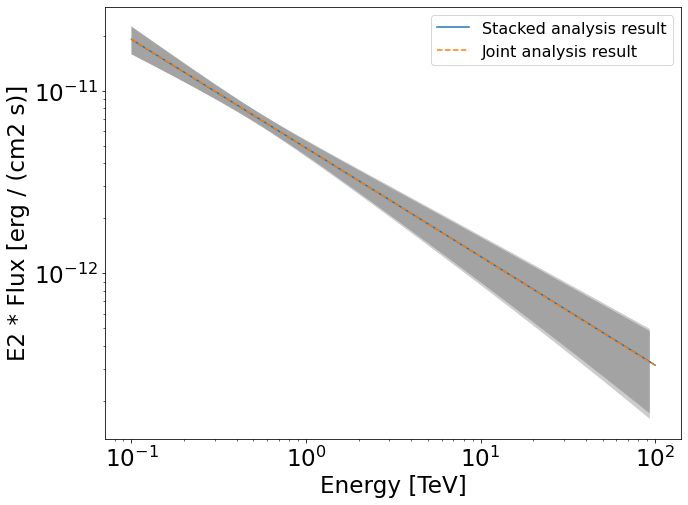

In [94]:
fig = plt.figure()
plot_kwargs = {
    "energy_range": [0.1, 100] * u.TeV,
    "energy_power": 2,
    "flux_unit": "erg-1 cm-2 s-1",
}

# plot stacked model
stacked = model_best_stacked.spectral_model.plot(
    **plot_kwargs, label="Stacked analysis result"
)
error= model_best_stacked.spectral_model.plot_error(**plot_kwargs)

# plot joint model
joint = model_best_joint.spectral_model.plot(
    **plot_kwargs, label="Joint analysis result", ls="--"
)
model_best_joint.spectral_model.plot_error(**plot_kwargs)
l = plt.legend()

save(fig, 'Model_comparison_joint_stack')



## Flux_computation for stacked analysis.

In [95]:
%%time
fpe = FluxPointsEstimator( e_edges = ebounds*u.TeV, reoptimize = True)

with np.errstate(divide='ignore', invalid='ignore'):
    flux_points = fpe.run(datasets=dataset_stacked)

CPU times: user 1.28 s, sys: 7.08 ms, total: 1.28 s
Wall time: 1.29 s


In [96]:
flux_points.table_formatted

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,success,norm_err,norm_errp,norm_errn,norm_ul,sqrt_ts,ts,null_value,norm_scan [11],stat_scan [11],counts [1],dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64
0.205,0.178,0.237,1.844e-10,1.100e-11,2.241e-12,7.778e-12,0.592,0.351,True,0.190,0.205,0.176,1.034,4.443,19.738,0,0.200 .. 5.000,6.681 .. 130.680,18,1.093e-10,1.907e-10,3.513e-11,3.788e-11,3.249e-11
0.294,0.237,0.365,7.251e-11,9.395e-12,2.718e-12,6.279e-12,0.675,5.018,True,0.138,0.141,0.128,0.971,7.203,51.876,0,0.200 .. 5.000,24.329 .. 282.490,46,4.898e-11,7.042e-11,1.004e-11,1.023e-11,9.298e-12
0.422,0.365,0.487,2.851e-11,3.490e-12,1.461e-12,5.069e-12,1.325,2.786,True,0.211,0.221,0.201,1.787,10.570,111.722,0,0.200 .. 5.000,64.411 .. 126.033,51,3.778e-11,5.094e-11,6.012e-12,6.300e-12,5.732e-12
0.562,0.487,0.649,1.351e-11,2.206e-12,1.231e-12,4.272e-12,1.439,2.181,True,0.189,0.252,0.226,1.966,10.473,109.684,0,0.200 .. 5.000,63.906 .. 97.169,45,1.944e-11,2.656e-11,2.554e-12,3.398e-12,3.057e-12
0.750,0.649,0.866,6.401e-12,1.394e-12,1.037e-12,3.599e-12,1.200,0.131,True,0.251,0.266,0.235,1.765,8.215,67.486,0,0.200 .. 5.000,34.469 .. 86.023,29,7.683e-12,1.130e-11,1.604e-12,1.705e-12,1.506e-12
1.075,0.866,1.334,2.516e-12,1.191e-12,1.258e-12,2.906e-12,1.316,2.087,True,0.209,0.272,0.241,1.892,9.035,81.623,0,0.200 .. 5.000,45.239 .. 83.931,32,3.313e-12,4.760e-12,5.252e-13,6.852e-13,6.065e-13
1.540,1.334,1.778,9.893e-13,4.423e-13,6.760e-13,2.346e-12,0.742,2.715,True,0.307,0.335,0.267,1.489,4.088,16.712,0,0.200 .. 5.000,8.620 .. 54.561,8,7.342e-13,1.473e-12,3.037e-13,3.318e-13,2.639e-13
2.054,1.778,2.371,4.688e-13,2.795e-13,5.697e-13,1.977e-12,0.687,0.084,True,0.355,0.408,0.305,1.620,3.225,10.399,0,0.200 .. 5.000,3.417 .. 35.987,5,3.222e-13,7.592e-13,1.663e-13,1.914e-13,1.429e-13


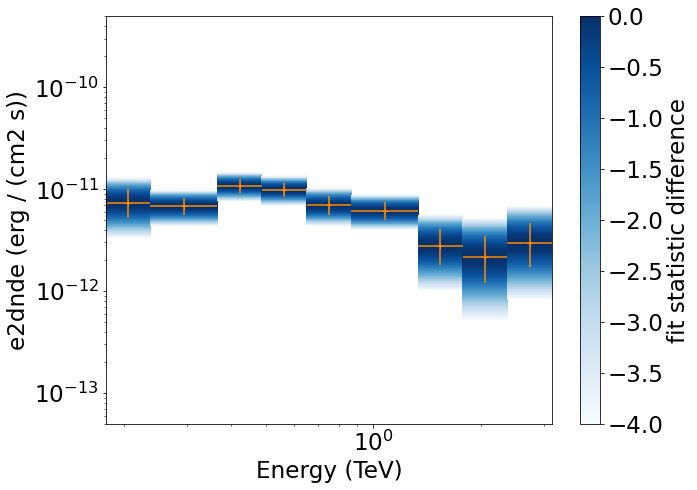

In [97]:
plt.figure()
fp = flux_points.table["is_ul"] = flux_points.table["ts"] < 4
ax = flux_points.plot(
    energy_power=2, flux_unit="erg-1 cm-2 s-1", color="darkorange"
)
sedp = flux_points.to_sed_type("e2dnde").plot_ts_profiles(ax=ax)
ax.set_ylim(5e-14, 5e-10);

save(fig, name_file2 + "TS_SED_profile_stacked")

In [98]:
flux_points_dataset = FluxPointsDataset(
    data=flux_points, models=model_best_stacked
)

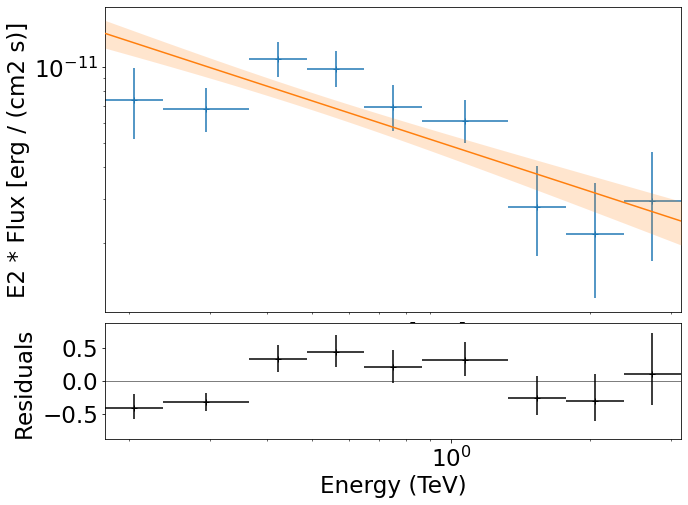

In [99]:
fig = plt.figure()
flux_points_dataset.peek();
save(fig, name_file2 + 'flux_points_peek_stacked')

## Save fluxpoints and model stacked

In [100]:
# Print and save flux point results
print('Flux points\n')
print('Unit: TeV^-1 cm^-2 s^-1')
print('')
print('Energy [TeV]  | E_min [TeV] | E_max [TeV]  |   Flux  |  Flux low | Flux high |  Significance')
E_ref = flux_points.table['e_ref']
E_min = flux_points.table['e_min']
E_max = flux_points.table['e_max']

flux    = flux_points.table['dnde']
fluxerr = flux_points.table['dnde_err']
fluxul  = flux_points.table['dnde_ul']
sqrtts  = flux_points.table['sqrt_ts']
isul    = sqrtts < 2
for e,emin,emax,f,fl,fh,lim,ul,s in zip(E_ref,E_min, E_max, flux, flux-fluxerr, flux+fluxerr, fluxul, isul, sqrtts):
    if ul:
        print('{:^14.3f}|{:^14.3f}|{:^14.3f}|{:^16s}|{:16s}|{:16s}|{:^16.2f}'.format(e,emin,emax, '< {:.4g}'.format(lim), ' ', ' ', s))
    else:
        print('{:^14.3f}|{:^14.3f}|{:^14.3f}|{:^16.4g}|{:^16.4g}|{:^16.4g}|{:^16.2f}'.format(e,emin,emax, f, f-fl, f+fh, s))

Flux points

Unit: TeV^-1 cm^-2 s^-1

Energy [TeV]  | E_min [TeV] | E_max [TeV]  |   Flux  |  Flux low | Flux high |  Significance
    0.205     |    0.178     |    0.237     |   1.093e-10    |   3.513e-11    |   2.537e-10    |      4.44      
    0.294     |    0.237     |    0.365     |   4.898e-11    |   1.004e-11    |    1.08e-10    |      7.20      
    0.422     |    0.365     |    0.487     |   3.778e-11    |   6.012e-12    |   8.156e-11    |     10.57      
    0.562     |    0.487     |    0.649     |   1.944e-11    |   2.554e-12    |   4.144e-11    |     10.47      
    0.750     |    0.649     |    0.866     |   7.683e-12    |   1.604e-12    |   1.697e-11    |      8.21      
    1.075     |    0.866     |    1.334     |   3.313e-12    |   5.252e-13    |    7.15e-12    |      9.03      
    1.540     |    1.334     |    1.778     |   7.342e-13    |   3.037e-13    |   1.772e-12    |      4.09      
    2.054     |    1.778     |    2.371     |   3.222e-13    |   1.663e-13    

In [101]:
flux_points_dataset = FluxPointsDataset(data = flux_points, models = model_best_stacked)
flux_points_dataset.residuals = my_residuals
residuals , res_err = flux_points_dataset.residuals(flux_points_dataset, method = "diff/model")
flux_points.table["residuals"] = residuals
flux_points.table["res_errd"] = res_err[0]
flux_points.table["res_erru"] = res_err[1]
#flux_points.table['is_ul'] = flux_points.table['sqrt_ts'] < 2  # set threshold to 2 sigma
flux_points.table_formatted

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,success,norm_err,norm_errp,norm_errn,norm_ul,sqrt_ts,ts,null_value,norm_scan [11],stat_scan [11],counts [1],dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn,is_ul,residuals,res_errd,res_erru
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,bool,float64,float64,float64
0.205,0.178,0.237,1.844e-10,1.100e-11,2.241e-12,7.778e-12,0.592,0.351,True,0.190,0.205,0.176,1.034,4.443,19.738,0,0.200 .. 5.000,6.681 .. 130.680,18,1.093e-10,1.907e-10,3.513e-11,3.788e-11,3.249e-11,False,-0.40758433661369686,0.17617059985007422,0.20540262716354662
0.294,0.237,0.365,7.251e-11,9.395e-12,2.718e-12,6.279e-12,0.675,5.018,True,0.138,0.141,0.128,0.971,7.203,51.876,0,0.200 .. 5.000,24.329 .. 282.490,46,4.898e-11,7.042e-11,1.004e-11,1.023e-11,9.298e-12,False,-0.324550681556456,0.12822834058051702,0.14114749242120853
0.422,0.365,0.487,2.851e-11,3.490e-12,1.461e-12,5.069e-12,1.325,2.786,True,0.211,0.221,0.201,1.787,10.570,111.722,0,0.200 .. 5.000,64.411 .. 126.033,51,3.778e-11,5.094e-11,6.012e-12,6.300e-12,5.732e-12,False,0.3251674557290816,0.2010845313977288,0.22100833827927563
0.562,0.487,0.649,1.351e-11,2.206e-12,1.231e-12,4.272e-12,1.439,2.181,True,0.189,0.252,0.226,1.966,10.473,109.684,0,0.200 .. 5.000,63.906 .. 97.169,45,1.944e-11,2.656e-11,2.554e-12,3.398e-12,3.057e-12,False,0.4394547546536796,0.22629692007048846,0.251577522254711
0.750,0.649,0.866,6.401e-12,1.394e-12,1.037e-12,3.599e-12,1.200,0.131,True,0.251,0.266,0.235,1.765,8.215,67.486,0,0.200 .. 5.000,34.469 .. 86.023,29,7.683e-12,1.130e-11,1.604e-12,1.705e-12,1.506e-12,False,0.2003023448059481,0.23534669968584435,0.2663430836188867
1.075,0.866,1.334,2.516e-12,1.191e-12,1.258e-12,2.906e-12,1.316,2.087,True,0.209,0.272,0.241,1.892,9.035,81.623,0,0.200 .. 5.000,45.239 .. 83.931,32,3.313e-12,4.760e-12,5.252e-13,6.852e-13,6.065e-13,False,0.3164371034157796,0.2410307565760819,0.2722824831273683
1.540,1.334,1.778,9.893e-13,4.423e-13,6.760e-13,2.346e-12,0.742,2.715,True,0.307,0.335,0.267,1.489,4.088,16.712,0,0.200 .. 5.000,8.620 .. 54.561,8,7.342e-13,1.473e-12,3.037e-13,3.318e-13,2.639e-13,False,-0.2577965857831756,0.2667887933268995,0.3354456774354333
2.054,1.778,2.371,4.688e-13,2.795e-13,5.697e-13,1.977e-12,0.687,0.084,True,0.355,0.408,0.305,1.620,3.225,10.399,0,0.200 .. 5.000,3.417 .. 35.987,5,3.222e-13,7.592e-13,1.663e-13,1.914e-13,1.429e-13,False,-0.3127273864468308,0.30475640584588226,0.40830997391201346


In [103]:
flux_points.write('../flux_and_fit_results/night1_1d_flux_points_v17_stacked.ecsv',
                  include_names=['e_ref', 'e_min', 'e_max',
                                 'dnde', 'dnde_err', 'dnde_errp', 'dnde_errn', 'dnde_ul',
                                 'is_ul', 'sqrt_ts', 'residuals','res_errd','res_erru' ],
                  overwrite=True)


model_best_stacked.parameters.to_table().write('../flux_and_fit_results/night1_1d_fit17_stacked.csv', overwrite=True)


In [104]:
ref_flux = flux_points.table['ref_flux'].data
ref_e = flux_points.table['e_ref'].data
err_min = flux_points.table['e_min'].data
err_max = flux_points.table['e_max'].data
dnde = flux_points.table['dnde'].data
dnde_ref = flux_points.table['ref_dnde'].data
dnde_err = flux_points.table['dnde_err'].data
dnde_low_err = flux_points.table['dnde_errn'].data
dnde_upper_err = flux_points.table['dnde_errp'].data

errlow = ref_e - err_min 
errhigh = err_max - ref_e
xerr = [errlow, errhigh]
yerr = [dnde_err*errlow**2, dnde_err*errhigh**2]

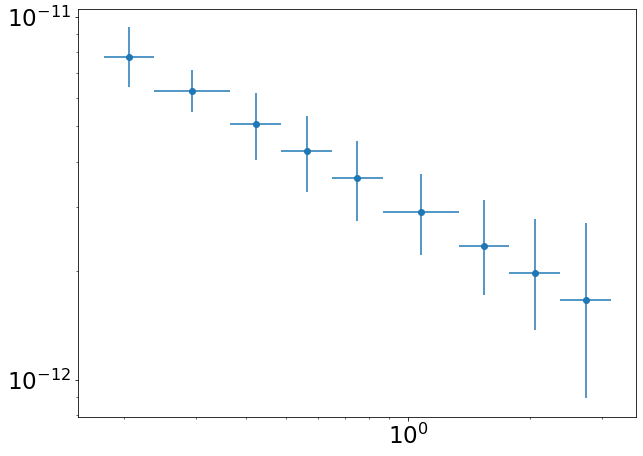

In [105]:
plt.errorbar(ref_e, ref_e**2 * dnde_ref, yerr = ref_e**2 * [dnde_low_err, dnde_upper_err], xerr = xerr, 
            marker = 'o', linestyle= 'none')
plt.xscale('log')
plt.yscale('log')

#### What next?

- The methods shown in this tutorial is valid for point-like or midly extended sources where we can assume that the IRF taken at the region in the center is valid over the whole region. 
- If one wants to extract the 1D spectrum of a large source and properly average the response over the extraction region, one has to use a different approach explained in the `extended source spectral analysis tutorial`.

- The next step will be to work on the code that analyse all nights at once. But I should do all analysis in notebook too. 

In [106]:
ebounds = np.logspace(-0.75, 0.52, 10)

ebounds = ebounds[ebounds.searchsorted(min_energy.value+1e-4)-1:]

In [107]:
ebounds

array([0.17782794, 0.24609972, 0.34058242, 0.47133895, 0.65229559,
       0.90272518, 1.24929979, 1.72893146, 2.39270352, 3.31131121])